In [85]:
#%matplotlib notebook
%matplotlib inline

import ComunicationClasses.Database_collector

import matplotlib.pyplot as plt

import pandas as pd

from math import pi
from numpy import array
from scipy.optimize import minimize
from DataAnalysisClasses.SensorCurve3D import SensorCurve3D
from DataAnalysisClasses.AngleCalculator import AngleCalculator
from DataAnalysisClasses.KalmanFilter import KalmanFilter
from DataAnalysisClasses.BiasCompensator import BiasCompensator
from ComunicationClasses.Database_collector import Database_collector
from DataAnalysisClasses.GeometryConstants import GeometryVectors

plt.ion()

# Get IMU data from database

## Create DB client and test connection

In [86]:
print('Testing connection')
db_host_address = 'localhost'
print('Server IP: ' + db_host_address)
db_client = Database_collector()
if not db_client.check_connection():
    raise RuntimeError('No dataframe connection')
else:
    print('Connection ok')

Testing connection
Server IP: localhost
Connection ok


In [87]:
print('List of databases:')
print(db_client.get_db_list())

print('List of measurements:')
print(db_client.get_measurements_list('scan_sensor_test'))

List of databases:
['scan_sensor_test']
List of measurements:
['ISM_330_raw', 'MPU_9255_raw', 'scanner_raw']


### Get raw data from inertial sensors

In [88]:
#time_start=1644518082462
#time_stop = 1644518106858
# time_start=1652530355
# time_stop = 1652530381
time_start=1695570386
time_stop = 1695570410
data_raw_ISM = db_client.get_measurement_data('scan_sensor_test', 'ISM_330_raw', time_start, time_stop).dropna()
data_raw_MPU = db_client.get_measurement_data('scan_sensor_test', 'MPU_9255_raw', time_start, time_stop).dropna()

### Compensate initial bias

In [89]:
bias_ISM = BiasCompensator('ISM_330', 'linear')
bias_MPU = BiasCompensator('MPU_9255', 'linear')
# Use first seconds to get gyro bias|
bias_ISM.set_gyro_const_bias(2000, data_raw_ISM)
bias_MPU.set_gyro_const_bias(2000, data_raw_MPU)

In [90]:
# Apply bias compensation
data_bias_ISM = bias_ISM.apply_bias(data_raw_ISM)
data_bias_MPU = bias_MPU.apply_bias(data_raw_MPU)

### Rotate vectors of IMU data

In [91]:
device_geometry = GeometryVectors()
data_rot_ISM = device_geometry.rotation_apply_vect(data_bias_ISM,['acc_X_b','acc_Y_b','acc_Z_b'],'ISM_330')
data_rot_ISM = device_geometry.rotation_apply_vect(data_rot_ISM,['gyro_X_b','gyro_Y_b','gyro_Z_b'],'ISM_330')
data_rot_MPU = device_geometry.rotation_apply_vect(data_bias_MPU,['acc_X_b','acc_Y_b','acc_Z_b'],'MPU_9255')
data_rot_MPU = device_geometry.rotation_apply_vect(data_rot_MPU,['gyro_X_b','gyro_Y_b','gyro_Z_b'],'MPU_9255')
# drop unneded columns
data_rot_ISM.drop(columns=['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z'], inplace=True)
data_rot_MPU.drop(columns=['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z'], inplace=True)

print(data_rot_ISM.describe())

print(data_bias_ISM.describe())

print(data_rot_MPU.describe())

print(data_bias_MPU.describe())

### Show two sensors data against each other

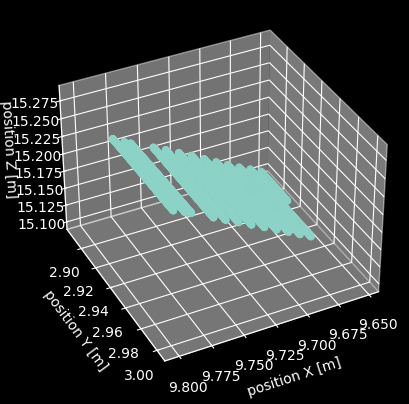

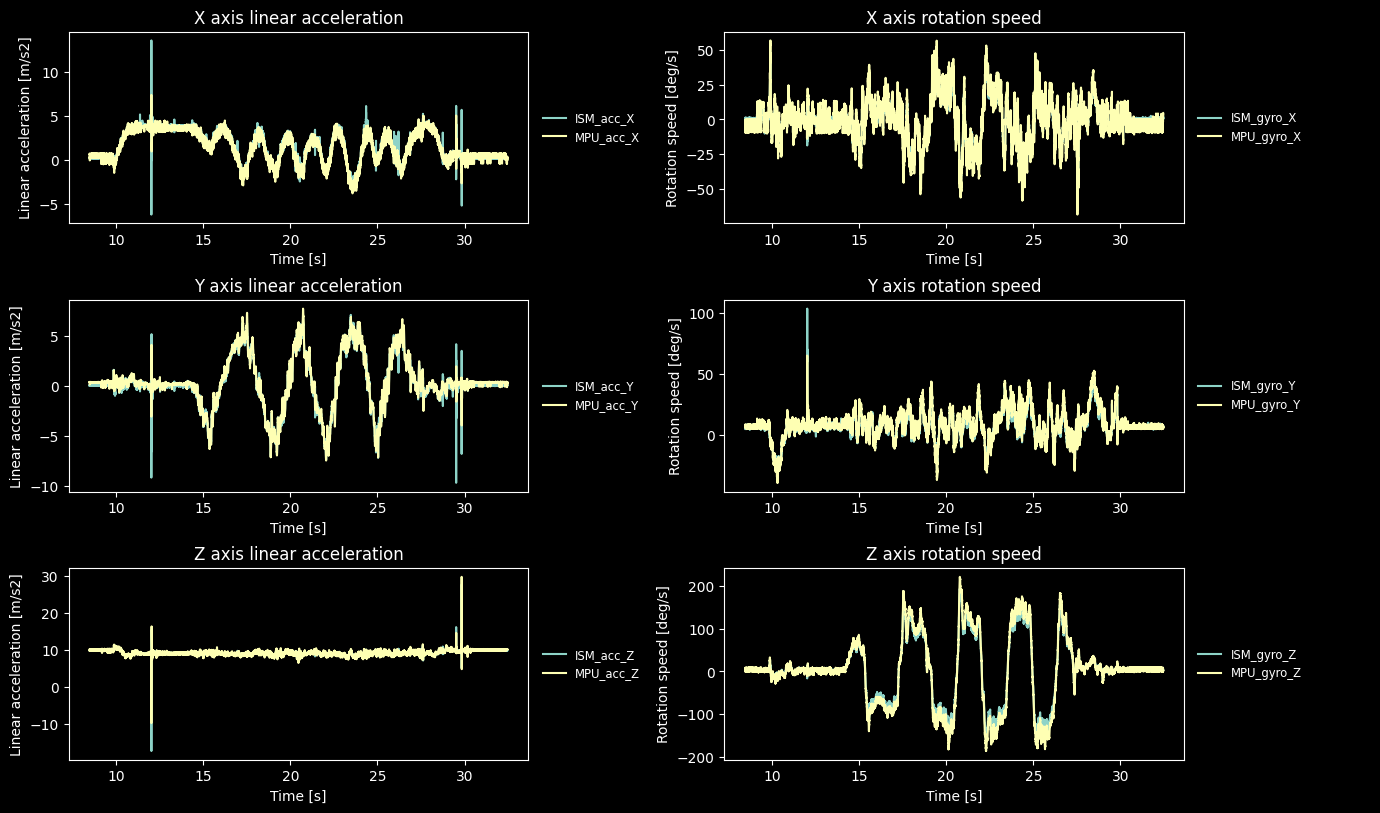

In [92]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_X_b'], label='ISM_acc_X')
axis[0, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_X_b'], label='MPU_acc_X')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_X_b'], label='ISM_gyro_X')
axis[0, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_X_b'], label='MPU_gyro_X')
axis[0, 2].set_title('X axis rotation speed')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Y_b'], label='ISM_acc_Y')
axis[1, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Y_b'], label='MPU_acc_Y')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Y_b'], label='ISM_gyro_Y')
axis[1, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Y_b'], label='MPU_gyro_Y')
axis[1, 2].set_title('Y axis rotation speed')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Z_b'], label='ISM_acc_Z')
axis[2, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Z_b'], label='MPU_acc_Z')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Z_b'], label='ISM_gyro_Z')
axis[2, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Z_b'], label='MPU_gyro_Z')
axis[2, 2].set_title('Z axis rotation speed')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Calculate acceleration vector in new point (holding only translated data)

In [93]:
# Calculate angular speed derivative from 3 consecutive samples

def derivative(df_in,column_name):
    df_temp = df_in[[column_name]].rolling(window=301, center=True, win_type="gaussian").mean(std=60)
    df_temp['prev'] = df_temp[column_name].shift(1)
    df_temp['next'] = df_temp[column_name].shift(-1)
    #df_temp['prev'] = df_in[column_name].shift(1)
    #df_temp['next'] = df_in[column_name].shift(-1)
    #print(df_temp.head())
    df_in[column_name+'_der']=((df_temp['next']-df_temp['prev'])/2)*1000
    
derivative(data_rot_ISM,'gyro_X_b')
derivative(data_rot_ISM,'gyro_Y_b')
derivative(data_rot_ISM,'gyro_Z_b')
derivative(data_rot_MPU,'gyro_X_b')
derivative(data_rot_MPU,'gyro_Y_b')
derivative(data_rot_MPU,'gyro_Z_b')

data_rot_ISM.fillna(0.0, inplace=True)
data_rot_MPU.fillna(0.0, inplace=True)
#print(data_rot_ISM.head())
#data_rot_ISM['mean_acc_Z_b'].rolling(window=3, center = True).apply(moving_derivative, raw=True)
#data_rot_MPU.rolling(window=3).apply(mad, raw=True)

In [94]:
data_rot_ISM.to_csv('ism_test.csv')

### Show derivative lowpass filter frame

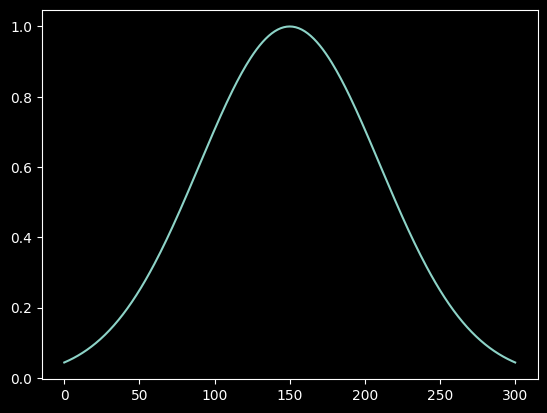

In [95]:
from scipy import signal
window = signal.windows.gaussian(301, std=60)
ax1 = plt.figure().add_subplot()
ax1.plot(window)

### Show rotation speed derivatives

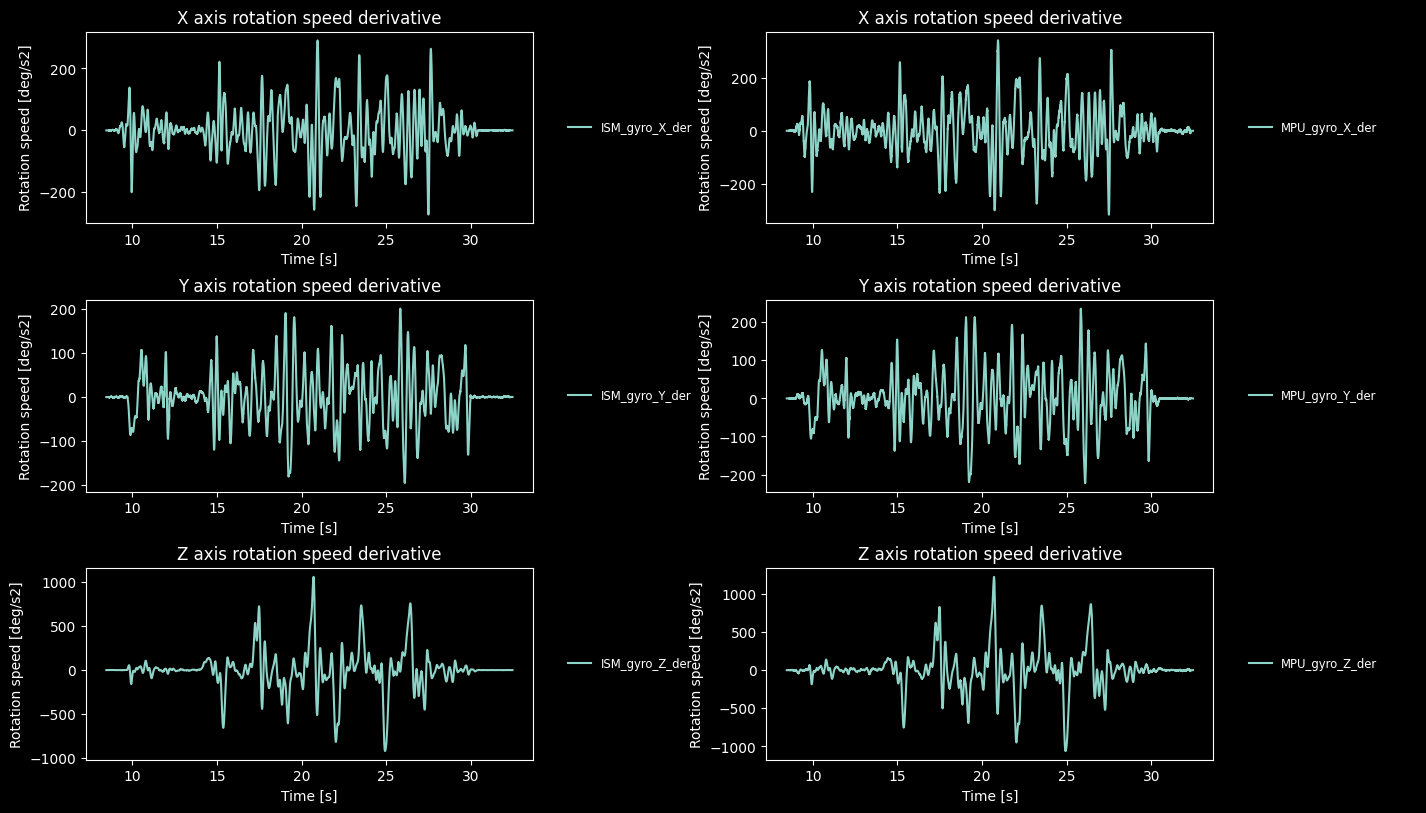

In [96]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_X_b_der'], label='ISM_gyro_X_der')
axis[0, 0].set_title('X axis rotation speed derivative')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot

axis[0, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_X_b_der'], label='MPU_gyro_X_der')
axis[0, 2].set_title('X axis rotation speed derivative')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Y_b_der'], label='ISM_gyro_Y_der')
axis[1, 0].set_title('Y axis rotation speed derivative')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot

axis[1, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Y_b_der'], label='MPU_gyro_Y_der')
axis[1, 2].set_title('Y axis rotation speed derivative')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Z_b_der'], label='ISM_gyro_Z_der')
axis[2, 0].set_title('Z axis rotation speed derivative')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot

axis[2, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Z_b_der'], label='MPU_gyro_Z_der')
axis[2, 2].set_title('Z axis rotation speed derivative')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=1, 
                    top=0.97, 
                    wspace=0.1, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Translate acceleration to scanner zero point

In [97]:
# Translate acceleration to scanner zero point
data_trans_ISM=device_geometry.translate_acceleration_vect(df_in=data_rot_ISM, 
                                                      sensor='ISM_330', 
                                                      acc_names=['acc_X_b','acc_Y_b','acc_Z_b'], 
                                                      gyro_names=['gyro_X_b','gyro_Y_b','gyro_Z_b'], 
                                                      gyro_der_names=['gyro_X_b_der','gyro_Y_b_der','gyro_Z_b_der'], 
                                                      output_names=['acc_X_t','acc_Y_t','acc_Z_t'], 
                                                      ang_unit='deg')
#data_trans_ISM.drop(['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b','mean_gyro_X_b_der','mean_gyro_Y_b_der','mean_gyro_Z_b_der'])

data_trans_MPU=device_geometry.translate_acceleration_vect(df_in=data_rot_MPU, 
                                                      sensor='MPU_9255', 
                                                      acc_names=['acc_X_b','acc_Y_b','acc_Z_b'], 
                                                      gyro_names=['gyro_X_b','gyro_Y_b','gyro_Z_b'], 
                                                      gyro_der_names=['gyro_X_b_der','gyro_Y_b_der','gyro_Z_b_der'], 
                                                      output_names=['acc_X_t','acc_Y_t','acc_Z_t'], 
                                                      ang_unit='deg')
#data_trans_MPU.drop(['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b','mean_gyro_X_b_der','mean_gyro_Y_b_der','mean_gyro_Z_b_der'])

In [98]:
data_trans_ISM.describe()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,20.461749,1.661369,0.220447,9.209478,-0.758754,7.521929,2.763445,0.003725,0.002572,0.002687,1.481843,0.066517,9.184341
std,6.928347,1.747861,2.541810,0.616918,13.337399,10.260597,70.595295,73.319956,59.008120,222.470204,1.877846,2.832586,0.672210
min,8.462265,-6.204139,-9.704487,-17.324210,-54.379075,-32.593957,-159.045903,-271.807655,-195.594392,-920.952740,-6.153833,-9.754012,-17.567698
25%,14.462029,0.208800,-0.546636,8.868497,-5.712439,3.376095,-29.920435,-33.522282,-28.007665,-44.841455,0.200739,-0.788020,8.833250
50%,20.461693,1.619507,0.014798,9.126464,-0.065415,7.243689,2.990230,0.000000,0.000000,0.042540,1.445585,0.010098,9.119702
75%,26.461453,3.365455,1.192699,9.675372,5.656631,11.336096,31.855281,29.780881,26.631162,43.118706,3.219139,0.853383,9.725649
max,32.461235,13.550140,7.072941,27.647997,45.360000,103.555131,193.511470,290.227852,201.526817,1060.990495,13.560795,8.540446,27.846525


In [99]:
data_trans_MPU.describe()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,20.461748,1.466660,0.350098,9.236484,-0.197540,8.938670,1.895665,0.008670,-0.020704,0.003111,0.987878,-0.055146,9.171930
std,6.928347,1.744532,2.599821,0.717595,16.048195,12.125190,81.383844,85.930083,68.570533,256.001866,2.235636,3.382113,0.909612
min,8.462160,-3.795428,-7.478897,-9.789920,-68.168637,-38.862577,-186.408643,-316.220983,-221.688519,-1060.546974,-8.553443,-11.558320,-9.954194
25%,14.462089,0.269657,-0.466103,8.776589,-7.866206,4.328164,-37.624685,-40.068642,-30.047266,-51.954537,0.052141,-1.150571,8.636848
50%,20.461660,1.392144,0.280510,9.161186,-0.748815,7.672938,4.920549,-0.169763,0.000000,0.576113,0.885711,0.211307,9.134459
75%,26.461581,3.134630,1.190904,9.722550,9.390530,13.743801,35.303780,38.542034,32.713932,51.565146,2.852629,0.685332,9.890960
max,32.461240,7.372409,7.694961,29.684702,56.583187,65.170681,221.568143,340.933161,235.839426,1223.425458,7.452598,12.196221,30.130446


### Show translated accelerations compared to previous point

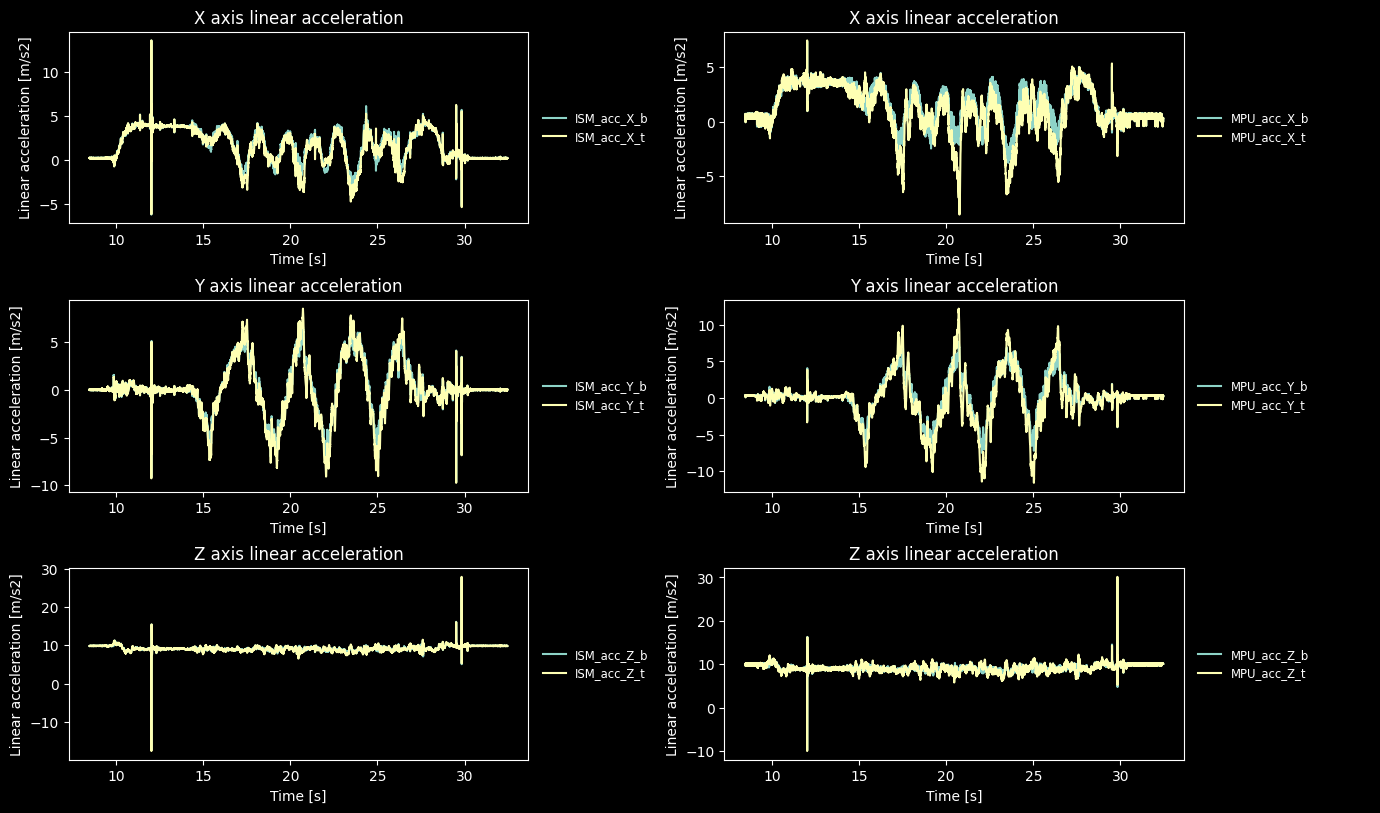

In [100]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_X_b'], label='ISM_acc_X_b')
axis[0, 0].plot(data_trans_ISM['time_rel'], data_trans_ISM['acc_X_t'], label='ISM_acc_X_t')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_X_b'], label='MPU_acc_X_b')
axis[0, 2].plot(data_trans_MPU['time_rel'], data_trans_MPU['acc_X_t'], label='MPU_acc_X_t')
axis[0, 2].set_title('X axis linear acceleration')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Y_b'], label='ISM_acc_Y_b')
axis[1, 0].plot(data_trans_ISM['time_rel'], data_trans_ISM['acc_Y_t'], label='ISM_acc_Y_t')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Y_b'], label='MPU_acc_Y_b')
axis[1, 2].plot(data_trans_MPU['time_rel'], data_trans_MPU['acc_Y_t'], label='MPU_acc_Y_t')
axis[1, 2].set_title('Y axis linear acceleration')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Z_b'], label='ISM_acc_Z_b')
axis[2, 0].plot(data_trans_ISM['time_rel'], data_trans_ISM['acc_Z_t'], label='ISM_acc_Z_t')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Z_b'], label='MPU_acc_Z_b')
axis[2, 2].plot(data_trans_MPU['time_rel'], data_trans_MPU['acc_Z_t'], label='MPU_acc_Z_t')
axis[2, 2].set_title('Z axis linear acceleration')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Join two sensors data in single point

In [101]:
data_trans_ISM.head()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
_time,,,,,,,,,,,,,
2023-09-24 15:46:26.001000+00:00,8.462265,0.224329,0.027384,9.841278,-0.121364,7.160274,2.786779,0.0,0.0,0.0,0.222476,0.027732,9.840304
2023-09-24 15:46:26.002000+00:00,8.463239,0.203026,0.003089,9.838096,-1.385300,5.011328,1.426204,0.0,0.0,0.0,0.201916,0.002973,9.837424
2023-09-24 15:46:26.003000+00:00,8.464269,0.206012,0.011453,9.861364,0.361831,7.941016,3.577693,0.0,0.0,0.0,0.203807,0.012017,9.860334
2023-09-24 15:46:26.004000+00:00,8.465327,0.233886,-0.023596,9.825369,0.509333,6.773718,2.674881,0.0,0.0,0.0,0.232402,-0.023160,9.824548
2023-09-24 15:46:26.005000+00:00,8.466207,0.221781,0.038217,9.834278,0.023086,7.316931,3.032954,0.0,0.0,0.0,0.219858,0.038622,9.833316


In [102]:
# Join two sensors data
ISM_weight = 100
MPU_weight = 1

# drop starting and ending rows with only one sensor 
start = max([data_trans_ISM.index[0],data_trans_MPU.index[0]])
end = min([data_trans_ISM.index[-1],data_trans_MPU.index[-1]])

#data_joined = (pd.concat((data_trans_ISM*ISM_weight, data_trans_MPU*MPU_weight), axis=1).mean(axis=1)/(ISM_weight+MPU_weight))#[start:end]
data_joined = pd.concat((data_trans_ISM.loc[start:end] * ISM_weight, data_trans_MPU.loc[start:end] * MPU_weight))#.mean(axis=0)#, axis=1)#.mean(axis=1)
data_joined=data_joined.groupby(data_joined.index).sum()/(ISM_weight + MPU_weight)

In [103]:
data_joined.head()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
_time,,,,,,,,,,,,,
2023-09-24 15:46:26.001000+00:00,8.462264,0.229026,0.030731,9.840397,-0.129586,7.155949,2.839440,0.0,0.0,0.0,0.227115,0.031064,9.839432
2023-09-24 15:46:26.002000+00:00,8.463241,0.208026,0.006491,9.836892,-1.465177,5.039604,1.408809,0.0,0.0,0.0,0.206847,0.006276,9.836134
2023-09-24 15:46:26.003000+00:00,8.464270,0.210892,0.014773,9.860020,0.347856,7.931311,3.621982,0.0,0.0,0.0,0.208630,0.015321,9.858999
2023-09-24 15:46:26.004000+00:00,8.465326,0.234323,-0.019937,9.828537,0.410615,6.786788,2.643544,0.0,0.0,0.0,0.232770,-0.019610,9.827631
2023-09-24 15:46:26.005000+00:00,8.466210,0.222232,0.041137,9.837285,-0.065895,7.318213,3.003422,0.0,0.0,0.0,0.220253,0.041449,9.836250


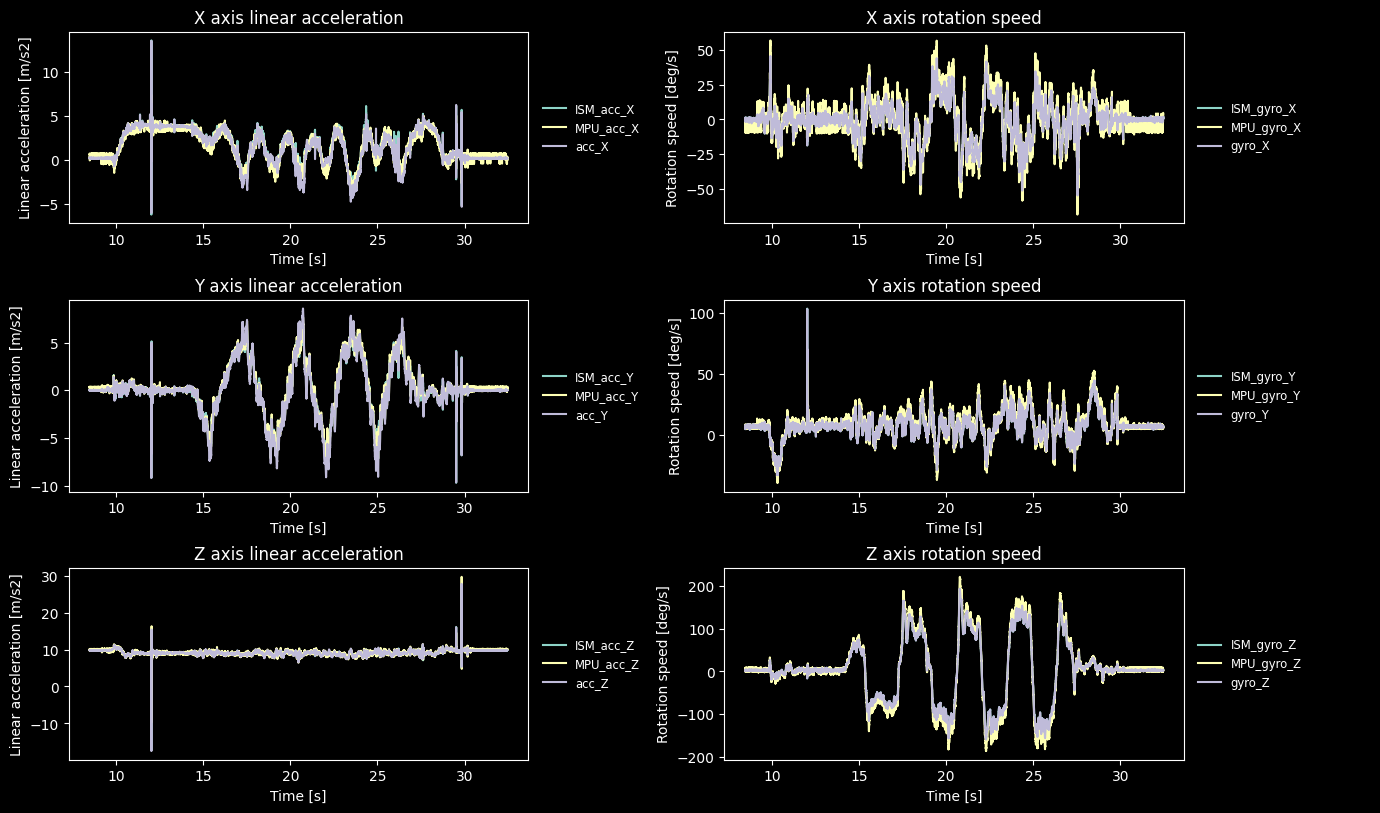

In [104]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_X_b'], label='ISM_acc_X')
axis[0, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_X_b'], label='MPU_acc_X')
axis[0, 0].plot(data_joined['time_rel'], data_joined['acc_X_t'], label='acc_X')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_X_b'], label='ISM_gyro_X')
axis[0, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_X_b'], label='MPU_gyro_X')
axis[0, 2].plot(data_joined['time_rel'], data_joined['gyro_X_b'], label='gyro_X')
axis[0, 2].set_title('X axis rotation speed')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Y_b'], label='ISM_acc_Y')
axis[1, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Y_b'], label='MPU_acc_Y')
axis[1, 0].plot(data_joined['time_rel'], data_joined['acc_Y_t'], label='acc_Y')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Y_b'], label='ISM_gyro_Y')
axis[1, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Y_b'], label='MPU_gyro_Y')
axis[1, 2].plot(data_joined['time_rel'], data_joined['gyro_Y_b'], label='gyro_Y')
axis[1, 2].set_title('Y axis rotation speed')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Z_b'], label='ISM_acc_Z')
axis[2, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Z_b'], label='MPU_acc_Z')
axis[2, 0].plot(data_joined['time_rel'], data_joined['acc_Z_t'], label='acc_Z')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Z_b'], label='ISM_gyro_Z')
axis[2, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Z_b'], label='MPU_gyro_Z')
axis[2, 2].plot(data_joined['time_rel'], data_joined['gyro_Z_b'], label='gyro_Z')
axis[2, 2].set_title('Z axis rotation speed')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

In [105]:
translator = AngleCalculator()
kalman = KalmanFilter()
data = data_joined.copy()

In [106]:
data.head()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
_time,,,,,,,,,,,,,
2023-09-24 15:46:26.001000+00:00,8.462264,0.229026,0.030731,9.840397,-0.129586,7.155949,2.839440,0.0,0.0,0.0,0.227115,0.031064,9.839432
2023-09-24 15:46:26.002000+00:00,8.463241,0.208026,0.006491,9.836892,-1.465177,5.039604,1.408809,0.0,0.0,0.0,0.206847,0.006276,9.836134
2023-09-24 15:46:26.003000+00:00,8.464270,0.210892,0.014773,9.860020,0.347856,7.931311,3.621982,0.0,0.0,0.0,0.208630,0.015321,9.858999
2023-09-24 15:46:26.004000+00:00,8.465326,0.234323,-0.019937,9.828537,0.410615,6.786788,2.643544,0.0,0.0,0.0,0.232770,-0.019610,9.827631
2023-09-24 15:46:26.005000+00:00,8.466210,0.222232,0.041137,9.837285,-0.065895,7.318213,3.003422,0.0,0.0,0.0,0.220253,0.041449,9.836250


In [107]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3):
    print(data.describe())
    

        time_rel    acc_X_b    acc_Y_b    acc_Z_b   gyro_X_b   gyro_Y_b  \
count  24000.000  24000.000  24000.000  24000.000  24000.000  24000.000   
mean      20.462      1.659      0.222      9.210     -0.753      7.536   
std        6.928      1.747      2.542      0.617     13.359     10.277   
min        8.462     -6.084     -9.606    -17.229    -54.451    -32.615   
25%       14.462      0.209     -0.545      8.868     -5.702      3.388   
50%       20.462      1.617      0.018      9.127     -0.083      7.251   
75%       26.461      3.364      1.192      9.675      5.677     11.357   
max       32.461     13.489      7.067     27.583     45.438    103.159   

        gyro_Z_b  gyro_X_b_der  gyro_Y_b_der  gyro_Z_b_der    acc_X_t  \
count  24000.000     24000.000     24000.000     24000.000  24000.000   
mean       2.755         0.004         0.002         0.003      1.477   
std       70.701        73.437        59.100       222.801      1.880   
min     -159.307      -272.224  

In [108]:
#data = bias.apply_bias(data)
# calculate phi and theta from accelerometers data
data = translator.calculate_angles_1(data)

In [109]:
# apply "Kalman filter" to phi and theta calculations (also get psi as an integral)
data = kalman.apply_kalman(data, extra=True)

In [110]:
# rotate sensors accelerations from sensor frame to earths frame using quaternions
data = translator.rotate_acc(data)

In [111]:
# get points 3D
curve = SensorCurve3D()

fun_iter = 0

In [112]:
    # def set_input_tables(self, x_acc, y_acc, z_acc, times):
    #     self.x_acc_list = x_acc[:]
    #     self.y_acc_list = y_acc[:]
    #     self.z_acc_list = z_acc[:]
    #     self.time_list = times[:]
    #     pass

curve.set_input_tables(x_acc=data['acc_X_e'].to_list(),y_acc=data['acc_Y_e'].to_list(), z_acc=data['acc_Z_e'].to_list(), times=data['time_rel'].to_list())

#curve.fill_curve(data, 9.8159, None)
curve.fill_curve_from_input_tables(9.8159, None)

In [113]:
print(data.describe())

           time_rel       acc_X_b       acc_Y_b       acc_Z_b      gyro_X_b  \
count  24000.000000  24000.000000  24000.000000  24000.000000  24000.000000   
mean      20.461749      1.659441      0.221731      9.209745     -0.753198   
std        6.928347      1.747417      2.542225      0.616873     13.358934   
min        8.462264     -6.084479     -9.606011    -17.229093    -54.450706   
25%       14.462029      0.209236     -0.544827      8.867624     -5.701537   
50%       20.461693      1.616927      0.017902      9.126783     -0.083233   
75%       26.461455      3.363861      1.191803      9.675238      5.676845   
max       32.461235     13.488975      7.067296     27.583347     45.438186   

           gyro_Y_b      gyro_Z_b  gyro_X_b_der  gyro_Y_b_der  gyro_Z_b_der  \
count  24000.000000  24000.000000  24000.000000  24000.000000  24000.000000   
mean       7.535956      2.754853      0.003774      0.002342      0.002691   
std       10.276666     70.701431     73.437329    

speed_corrections = {'x': curve.x_speed_last / 8000, 'y': curve.y_speed_last / 8000, 'z': curve.z_speed_last / 8000}
curve.fill_curve(data, 0.001, 9.8159, speed_corrections)

## Przyspieszenia w stosunku do ziemi

In [114]:
data[['acc_X_e','acc_Y_e','acc_Z_e']]

,acc_X_e,acc_Y_e,acc_Z_e
_time,,,
2023-09-24 15:46:26.001000+00:00,0.200240,0.027271,9.840027
2023-09-24 15:46:26.002000+00:00,0.142619,0.002161,9.837277
2023-09-24 15:46:26.003000+00:00,0.111275,0.008521,9.860587
2023-09-24 15:46:26.004000+00:00,0.096045,-0.018555,9.829920
2023-09-24 15:46:26.005000+00:00,0.059114,0.029699,9.838580
...,...,...,...
2023-09-24 15:46:49.996000+00:00,0.001301,0.002012,9.846668
2023-09-24 15:46:49.997000+00:00,-0.009752,-0.004515,9.871848
2023-09-24 15:46:49.998000+00:00,-0.000153,0.013835,9.849110


In [115]:
(data['acc_X_e']**2+data['acc_Y_e']**2+data['acc_Z_e']**2)**0.5

_time
2023-09-24 15:46:26.001000+00:00    9.842102
2023-09-24 15:46:26.002000+00:00    9.838311
2023-09-24 15:46:26.003000+00:00    9.861218
2023-09-24 15:46:26.004000+00:00    9.830406
2023-09-24 15:46:26.005000+00:00    9.838803
                                      ...   
2023-09-24 15:46:49.996000+00:00    9.846668
2023-09-24 15:46:49.997000+00:00    9.871854
2023-09-24 15:46:49.998000+00:00    9.849119
2023-09-24 15:46:49.999000+00:00    9.856997
2023-09-24 15:46:50+00:00           9.840266
Length: 24000, dtype: float64

In [116]:
### Przyspieszenia RAW 

In [117]:
data_raw_ISM[['acc_X','acc_Y','acc_Z']]

,acc_X,acc_Y,acc_Z
_time,,,
2023-09-24 15:46:26.001000+00:00,-9.824507,-0.079809,0.296092
2023-09-24 15:46:26.002000+00:00,-9.821315,-0.104151,0.274743
2023-09-24 15:46:26.003000+00:00,-9.844659,-0.095771,0.277736
2023-09-24 15:46:26.004000+00:00,-9.808545,-0.130887,0.305669
2023-09-24 15:46:26.005000+00:00,-9.817484,-0.068955,0.293538
...,...,...,...
2023-09-24 15:46:49.996000+00:00,-9.825505,-0.090982,0.271750
2023-09-24 15:46:49.997000+00:00,-9.851642,-0.078612,0.260178
2023-09-24 15:46:49.998000+00:00,-9.828019,-0.081405,0.286355


In [118]:
(data_raw_ISM['acc_X']**2+data_raw_ISM['acc_Y']**2+data_raw_ISM['acc_Z']**2)**0.5

_time
2023-09-24 15:46:26.001000+00:00    9.829292
2023-09-24 15:46:26.002000+00:00    9.825709
2023-09-24 15:46:26.003000+00:00    9.849042
2023-09-24 15:46:26.004000+00:00    9.814180
2023-09-24 15:46:26.005000+00:00    9.822113
                                      ...   
2023-09-24 15:46:49.996000+00:00    9.829683
2023-09-24 15:46:49.997000+00:00    9.855391
2023-09-24 15:46:49.998000+00:00    9.832527
2023-09-24 15:46:49.999000+00:00    9.840080
2023-09-24 15:46:50+00:00           9.823229
Length: 24000, dtype: float64

In [119]:
data_raw_MPU[['acc_X','acc_Y','acc_Z']]

,acc_X,acc_Y,acc_Z
_time,,,
2023-09-24 15:46:26.001000+00:00,4.905869,-5.420638,-6.842837
2023-09-24 15:46:26.002000+00:00,4.905869,-5.394301,-6.810514
2023-09-24 15:46:26.003000+00:00,4.905869,-5.394301,-6.823683
2023-09-24 15:46:26.004000+00:00,4.905869,-5.393104,-7.425843
2023-09-24 15:46:26.005000+00:00,4.905869,-5.375147,-7.428237
...,...,...,...
2023-09-24 15:46:49.996000+00:00,4.905869,-5.427821,-7.422252
2023-09-24 15:46:49.997000+00:00,4.905869,-5.429018,-7.416266
2023-09-24 15:46:49.998000+00:00,4.905869,-5.408667,-7.410280


In [120]:
(data_raw_MPU['acc_X']**2+data_raw_MPU['acc_Y']**2+data_raw_MPU['acc_Z']**2)**0.5

_time
2023-09-24 15:46:26.001000+00:00    10.013755
2023-09-24 15:46:26.002000+00:00     9.977432
2023-09-24 15:46:26.003000+00:00     9.986425
2023-09-24 15:46:26.004000+00:00    10.406549
2023-09-24 15:46:26.005000+00:00    10.398964
                                      ...    
2023-09-24 15:46:49.996000+00:00    10.422025
2023-09-24 15:46:49.997000+00:00    10.418387
2023-09-24 15:46:49.998000+00:00    10.403532
2023-09-24 15:46:49.999000+00:00    10.403534
2023-09-24 15:46:50+00:00           10.392510
Length: 24000, dtype: float64

In [121]:
### Przyspieszenia bias

In [122]:
data_bias_ISM[['acc_X_b','acc_Y_b','acc_Z_b']]

,acc_X_b,acc_Y_b,acc_Z_b
_time,,,
2023-09-24 15:46:26.001000+00:00,-9.841278,0.027384,0.224329
2023-09-24 15:46:26.002000+00:00,-9.838096,0.003089,0.203026
2023-09-24 15:46:26.003000+00:00,-9.861364,0.011453,0.206012
2023-09-24 15:46:26.004000+00:00,-9.825369,-0.023596,0.233886
2023-09-24 15:46:26.005000+00:00,-9.834278,0.038217,0.221781
...,...,...,...
2023-09-24 15:46:49.996000+00:00,-9.842272,0.016232,0.200039
2023-09-24 15:46:49.997000+00:00,-9.868324,0.028579,0.188492
2023-09-24 15:46:49.998000+00:00,-9.844778,0.025791,0.214613


In [123]:
(data_bias_ISM['acc_X_b']**2+data_bias_ISM['acc_Y_b']**2+data_bias_ISM['acc_Z_b']**2)**0.5

_time
2023-09-24 15:46:26.001000+00:00    9.843873
2023-09-24 15:46:26.002000+00:00    9.840191
2023-09-24 15:46:26.003000+00:00    9.863522
2023-09-24 15:46:26.004000+00:00    9.828180
2023-09-24 15:46:26.005000+00:00    9.836853
                                      ...   
2023-09-24 15:46:49.996000+00:00    9.844318
2023-09-24 15:46:49.997000+00:00    9.870166
2023-09-24 15:46:49.998000+00:00    9.847151
2023-09-24 15:46:49.999000+00:00    9.854832
2023-09-24 15:46:50+00:00           9.838154
Length: 24000, dtype: float64

In [124]:
data_bias_MPU[['acc_X_b','acc_Y_b','acc_Z_b']]

,acc_X_b,acc_Y_b,acc_Z_b
_time,,,
2023-09-24 15:46:26.001000+00:00,4.967075,-5.483903,-6.401798
2023-09-24 15:46:26.002000+00:00,4.967075,-5.457475,-6.369892
2023-09-24 15:46:26.003000+00:00,4.967075,-5.457475,-6.382891
2023-09-24 15:46:26.004000+00:00,4.967075,-5.456274,-6.977288
2023-09-24 15:46:26.005000+00:00,4.967075,-5.438255,-6.979652
...,...,...,...
2023-09-24 15:46:49.996000+00:00,4.967075,-5.491111,-6.973743
2023-09-24 15:46:49.997000+00:00,4.967075,-5.492312,-6.967835
2023-09-24 15:46:49.998000+00:00,4.967075,-5.471891,-6.961926


In [125]:
(data_bias_MPU['acc_X_b']**2+data_bias_MPU['acc_Y_b']**2+data_bias_MPU['acc_Z_b']**2)**0.5

_time
2023-09-24 15:46:26.001000+00:00     9.784071
2023-09-24 15:46:26.002000+00:00     9.748405
2023-09-24 15:46:26.003000+00:00     9.756904
2023-09-24 15:46:26.004000+00:00    10.155064
2023-09-24 15:46:26.005000+00:00    10.147019
                                      ...    
2023-09-24 15:46:49.996000+00:00    10.171393
2023-09-24 15:46:49.997000+00:00    10.167992
2023-09-24 15:46:49.998000+00:00    10.152923
2023-09-24 15:46:49.999000+00:00    10.151696
2023-09-24 15:46:50+00:00           10.140995
Length: 24000, dtype: float64

In [126]:
### Przyspieszenia Rotacja

In [127]:
data_rot_ISM[['acc_X_b','acc_Y_b','acc_Z_b']]

,acc_X_b,acc_Y_b,acc_Z_b
_time,,,
2023-09-24 15:46:26.001000+00:00,0.224329,0.027384,9.841278
2023-09-24 15:46:26.002000+00:00,0.203026,0.003089,9.838096
2023-09-24 15:46:26.003000+00:00,0.206012,0.011453,9.861364
2023-09-24 15:46:26.004000+00:00,0.233886,-0.023596,9.825369
2023-09-24 15:46:26.005000+00:00,0.221781,0.038217,9.834278
...,...,...,...
2023-09-24 15:46:49.996000+00:00,0.200039,0.016232,9.842272
2023-09-24 15:46:49.997000+00:00,0.188492,0.028579,9.868324
2023-09-24 15:46:49.998000+00:00,0.214613,0.025791,9.844778


In [128]:
(data_rot_ISM['acc_X_b']**2+data_rot_ISM['acc_Y_b']**2+data_rot_ISM['acc_Z_b']**2)**0.5

_time
2023-09-24 15:46:26.001000+00:00    9.843873
2023-09-24 15:46:26.002000+00:00    9.840191
2023-09-24 15:46:26.003000+00:00    9.863522
2023-09-24 15:46:26.004000+00:00    9.828180
2023-09-24 15:46:26.005000+00:00    9.836853
                                      ...   
2023-09-24 15:46:49.996000+00:00    9.844318
2023-09-24 15:46:49.997000+00:00    9.870166
2023-09-24 15:46:49.998000+00:00    9.847151
2023-09-24 15:46:49.999000+00:00    9.854832
2023-09-24 15:46:50+00:00           9.838154
Length: 24000, dtype: float64

In [129]:
data_rot_MPU[['acc_X_b','acc_Y_b','acc_Z_b']]

,acc_X_b,acc_Y_b,acc_Z_b
_time,,,
2023-09-24 15:46:26.001000+00:00,0.698734,0.365453,9.752244
2023-09-24 15:46:26.002000+00:00,0.708081,0.346765,9.716469
2023-09-24 15:46:26.003000+00:00,0.698890,0.346765,9.725661
2023-09-24 15:46:26.004000+00:00,0.277987,0.345916,10.145363
2023-09-24 15:46:26.005000+00:00,0.267306,0.333174,10.138024
...,...,...,...
2023-09-24 15:46:49.996000+00:00,0.297912,0.370549,10.160274
2023-09-24 15:46:49.997000+00:00,0.302691,0.371399,10.156697
2023-09-24 15:46:49.998000+00:00,0.296658,0.356958,10.142308


In [130]:
(data_rot_MPU['acc_X_b']**2+data_rot_MPU['acc_Y_b']**2+data_rot_MPU['acc_Z_b']**2)**0.5

_time
2023-09-24 15:46:26.001000+00:00     9.784071
2023-09-24 15:46:26.002000+00:00     9.748405
2023-09-24 15:46:26.003000+00:00     9.756904
2023-09-24 15:46:26.004000+00:00    10.155064
2023-09-24 15:46:26.005000+00:00    10.147019
                                      ...    
2023-09-24 15:46:49.996000+00:00    10.171393
2023-09-24 15:46:49.997000+00:00    10.167992
2023-09-24 15:46:49.998000+00:00    10.152923
2023-09-24 15:46:49.999000+00:00    10.151696
2023-09-24 15:46:50+00:00           10.140995
Length: 24000, dtype: float64

In [131]:
def opt_iteration(bias_tab):
    global fun_iter
    global data
    global data_joined
    global curve
    global translator
    #global kalman
    fun_iter += 1

    print('Func_call: ', fun_iter)
    print('Input: ', bias_tab)
    # apply new bias to input data
    #bias.change_bias_acc_linear(bias_tab[0], bias_tab[1], bias_tab[2], bias_tab[3], bias_tab[4], bias_tab[5])
    # bias.change_bias_gyro_const(bias_tab[3], bias_tab[4], bias_tab[5])
    # g_temp= bias_tab[6]
    g_temp = 9.8159
    data['acc_X_t'] = data_joined['acc_X_t'] + bias_tab[0]
    data['acc_Y_t'] = data_joined['acc_Y_t'] + bias_tab[1]
    data['acc_Z_t'] = data_joined['acc_Z_t'] + bias_tab[2]
    #bias.apply_bias(data)
    # recalculate Kalman
    #data = translator.calculate_angles_1(data)
    #data = kalman.apply_kalman(data)
    #print(data.describe())
    #print('0')
    data = translator.rotate_acc(data)
    #print('1')
    curve.set_input_tables(x_acc=data['acc_X_e'].to_list(),y_acc=data['acc_Y_e'].to_list(), z_acc=data['acc_Z_e'].to_list(), times=data['time_rel'].to_list())
    curve.fill_curve_from_input_tables(9.8159, None)
    #curve.fill_curve(data, g_temp,None)
    #print('2')
    speed_arg = curve.x_speed_last ** 2 + curve.y_speed_last ** 2 + curve.z_speed_last ** 2
    #print('3')
    pos_arg = curve.x_point_last ** 2 + curve.y_point_last ** 2 + curve.z_point_last ** 2
    #deg_arg = kalman.psi_hat ** 2
    #acc_arg = (curve.acc_last - 9.8159) ** 2
    out = speed_arg + pos_arg #+ acc_arg * 10000  + pos_arg# + deg_arg
    print('Output: ', out, ' dx: ', curve.x_speed_last)
    return out

In [132]:
# run single opt iteration
#x_0 = array([bias.bias_linear['a_x_acc'], bias.bias_linear['a_y_acc'], bias.bias_linear['a_z_acc'],
#                bias.bias_linear['b_x_acc'], bias.bias_linear['b_y_acc'], bias.bias_linear['b_z_acc']])
# x_0 = np.array([bias.bias_const['x_acc'], bias.bias_const['y_acc'], bias.bias_const['z_acc']])
#                bias.bias_const['x_gyro'], bias.bias_const['y_gyro'], bias.bias_const['z_gyro']])
x_0 = array([0.0,0.0,0.0])
# func = opt_iteration(x_0)
# print(func)
#data = data_joined.copy()
# minimize(opt_iteration, x_0, method='L-BFGS-B', bounds=[(-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1)],tol=0.01,
#         options={'eps': 0.01, 'iprint': 0, 'maxiter': 1})

# minimize(opt_iteration, x_0, method='L-BFGS-B',  # method='TNC',
#         bounds=[(0.98, 1.02), (0.98, 1.02), (0.98, 1.02), (-0.15, 0.15), (-0.15, 0.15), (-0.15, 0.15)],
#         options={'maxiter': 100, 'eps': 0.0001, 'ftol': 0.001})



# Get dataframe from device 3d curve

In [133]:
curve_df = curve.return_as_df()
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(curve_df.head())

                   X_p_e      Y_p_e      Z_p_e
mean_time_rel                                 
8.462          0.000e+00  0.000e+00  0.000e+00
8.463          8.181e-08  7.023e-09  1.086e-08
8.464          3.214e-07  2.464e-08  5.122e-08
8.465          6.940e-07  4.284e-08  1.270e-07
8.466          1.085e-06  5.789e-08  2.112e-07


In [134]:
data.set_index('time_rel', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(data.describe())

         acc_X_b    acc_Y_b    acc_Z_b   gyro_X_b   gyro_Y_b   gyro_Z_b  \
count  24000.000  24000.000  24000.000  24000.000  24000.000  24000.000   
mean       1.659      0.222      9.210     -0.753      7.536      2.755   
std        1.747      2.542      0.617     13.359     10.277     70.701   
min       -6.084     -9.606    -17.229    -54.451    -32.615   -159.307   
25%        0.209     -0.545      8.868     -5.702      3.388    -30.006   
50%        1.617      0.018      9.127     -0.083      7.251      3.005   
75%        3.364      1.192      9.675      5.677     11.357     31.915   
max       13.489      7.067     27.583     45.438    103.159    193.714   

       gyro_X_b_der  gyro_Y_b_der  gyro_Z_b_der    acc_X_t    acc_Y_t  \
count     24000.000     24000.000     24000.000  24000.000  24000.000   
mean          0.004         0.002         0.003      1.477      0.065   
std          73.437        59.100       222.801      1.880      2.837   
min        -272.224      -195.85

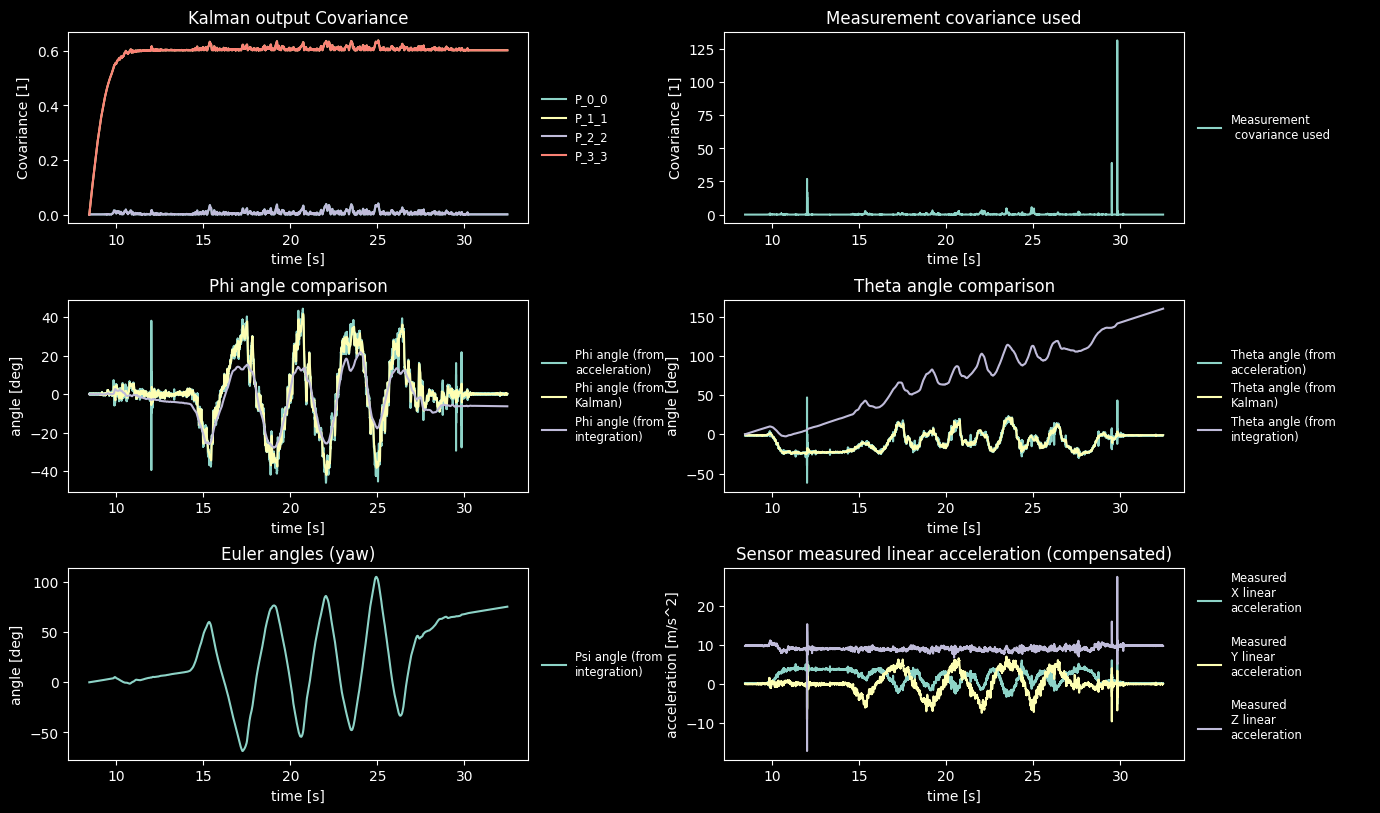

In [135]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot - Output estimate covariance
axis[0, 0].plot(data.index, data['P_0_0'], label='P_0_0')
axis[0, 0].plot(data.index, data['P_1_1'], label='P_1_1')
axis[0, 0].plot(data.index, data['P_2_2'], label='P_2_2')
axis[0, 0].plot(data.index, data['P_3_3'], label='P_3_3')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[0, 0].set_title('Kalman output Covariance')
axis[0, 0].set_xlabel('time [s]')
axis[0, 0].set_ylabel('Covariance [1]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")



# Second plot - Gyroscope data
axis[0, 2].plot(data.index, data['R'], label='Measurement\n covariance used')
axis[0, 2].set_title('Measurement covariance used')
axis[0, 2].set_xlabel('time [s]')
axis[0, 2].set_ylabel('Covariance [1]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot - Phi angle
axis[1, 0].plot(data.index, data['acc_phi'] * 180 / pi, label='Phi angle (from\nacceleration)')
axis[1, 0].plot(data.index, data['phi_hat'] * 180 / pi, label='Phi angle (from\nKalman)')
axis[1, 0].plot(data.index, data['int_phi'] * 180 / pi, label='Phi angle (from\nintegration)')
#axis[1, 0].plot(data.index, data['g_ground'], label='ground acceleration')
axis[1, 0].set_title('Phi angle comparison')
axis[1, 0].set_xlabel('time [s]')
axis[1, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot - Theta angle
axis[1, 2].plot(data.index, data['acc_theta'] * 180 / pi, label='Theta angle (from\nacceleration)')
axis[1, 2].plot(data.index, data['theta_hat'] * 180 / pi, label='Theta angle (from\nKalman)')
axis[1, 2].plot(data.index, data['int_theta'] * 180 / pi, label='Theta angle (from\nintegration)')
axis[1, 2].set_title('Theta angle comparison')
axis[1, 2].set_xlabel('time [s]')
axis[1, 2].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot - Psi angle from acceleration integration
axis[2, 0].plot(data.index, data['psi_hat'] * 180 / pi, label='Psi angle (from\nintegration)')
axis[2, 0].set_title('Euler angles (yaw)')
axis[2, 0].set_xlabel('time [s]')
axis[2, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot - Raw sensor acceleration data + bias compensation
axis[2, 2].plot(data.index, data['acc_X_b'], label='Measured\nX linear\nacceleration\n')
axis[2, 2].plot(data.index, data['acc_Y_b'], label='Measured\nY linear\nacceleration\n')
axis[2, 2].plot(data.index, data['acc_Z_b'], label='Measured\nZ linear\nacceleration\n')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[2, 2].set_title('Sensor measured linear acceleration (compensated)')
axis[2, 2].set_xlabel('time [s]')
axis[2, 2].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")
figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)


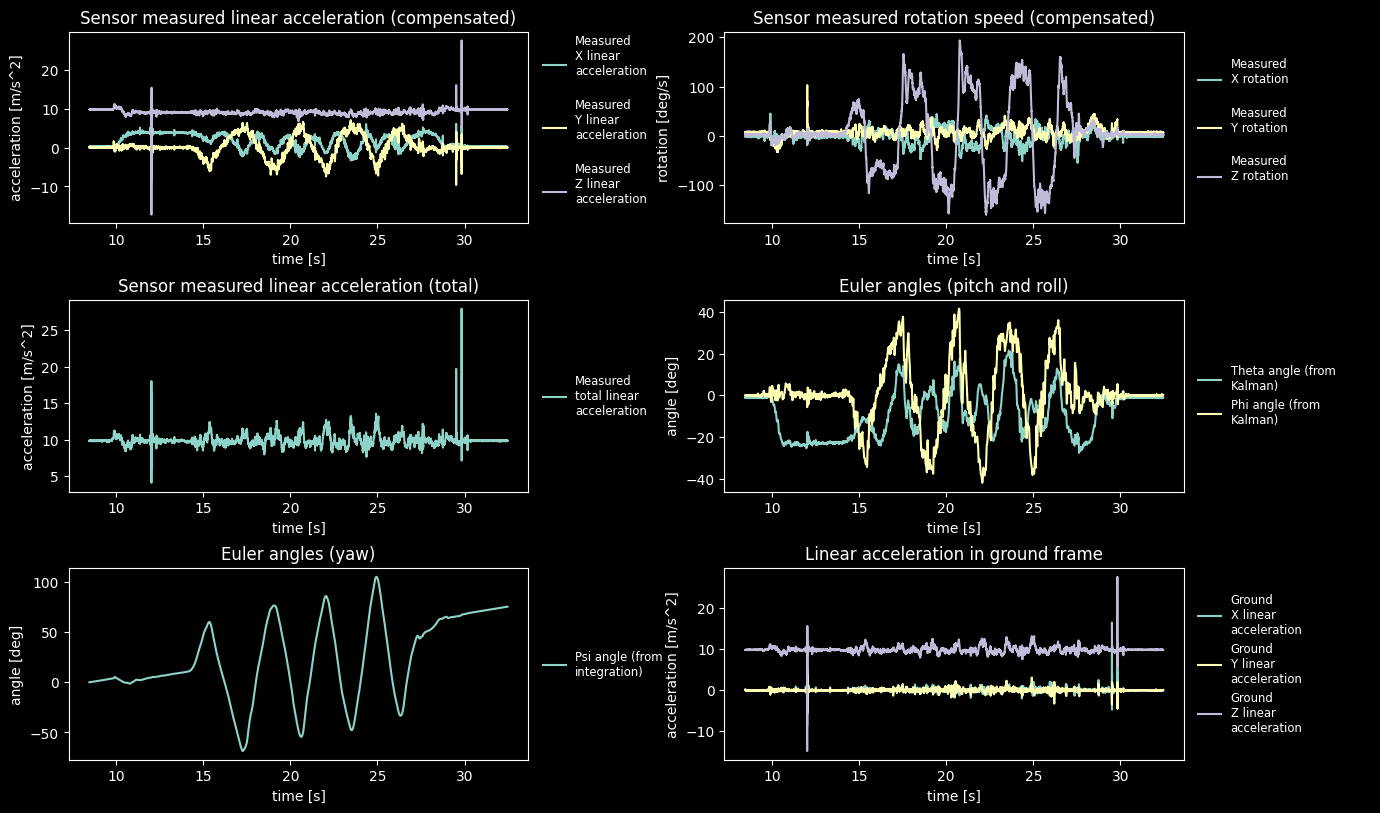

In [136]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot - Raw sensor acceleration data + bias compensation
axis[0, 0].plot(data.index, data['acc_X_b'], label='Measured\nX linear\nacceleration\n')
axis[0, 0].plot(data.index, data['acc_Y_b'], label='Measured\nY linear\nacceleration\n')
axis[0, 0].plot(data.index, data['acc_Z_b'], label='Measured\nZ linear\nacceleration\n')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[0, 0].set_title('Sensor measured linear acceleration (compensated)')
axis[0, 0].set_xlabel('time [s]')
axis[0, 0].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")



# Second plot - Gyroscope data
axis[0, 2].plot(data.index, data['gyro_X_b'], label='Measured\nX rotation\n')
axis[0, 2].plot(data.index, data['gyro_Y_b'], label='Measured\nY rotation\n')
axis[0, 2].plot(data.index, data['gyro_Z_b'], label='Measured\nZ rotation\n')
axis[0, 2].set_title('Sensor measured rotation speed (compensated)')
axis[0, 2].set_xlabel('time [s]')
axis[0, 2].set_ylabel('rotation [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot - Total acceleration (for checking whwther if translations work)
axis[1, 0].plot(data.index, data['g_sensor'], label='Measured\ntotal linear\nacceleration')
#axis[1, 0].plot(data.index, data['g_ground'], label='ground acceleration')
axis[1, 0].set_title('Sensor measured linear acceleration (total)')
axis[1, 0].set_xlabel('time [s]')
axis[1, 0].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot - Kalman angular input, output
axis[1, 2].plot(data.index, data['theta_hat'] * 180 / pi, label='Theta angle (from\nKalman)')
axis[1, 2].plot(data.index, data['phi_hat'] * 180 / pi, label='Phi angle (from\nKalman)')
axis[1, 2].set_title('Euler angles (pitch and roll)')
axis[1, 2].set_xlabel('time [s]')
axis[1, 2].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot - Phi angle from acceleration integration
axis[2, 0].plot(data.index, data['psi_hat'] * 180 / pi, label='Psi angle (from\nintegration)')
axis[2, 0].set_title('Euler angles (yaw)')
axis[2, 0].set_xlabel('time [s]')
axis[2, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot ground frame linear acceleration
axis[2, 2].plot(data.index, data['acc_X_e'], label='Ground\nX linear\nacceleration')
axis[2, 2].plot(data.index, data['acc_Y_e'], label='Ground\nY linear\nacceleration')
# axis[2, 1].plot(data.index, data['acc_Z_e'] - 9.8159, label='ground Z')
axis[2, 2].plot(data.index, data['acc_Z_e'], label='Ground\nZ linear\nacceleration')
axis[2, 2].set_title('Linear acceleration in ground frame')
axis[2, 2].set_xlabel('time [s]')
axis[2, 2].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")
figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)


Text(0.5, 0, 'position Z [m]')

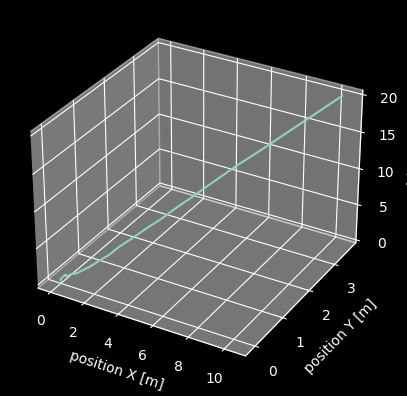

In [137]:
ax1 = plt.figure().add_subplot(projection='3d')
ax1.plot(curve.x_point_list, curve.y_point_list, curve.z_point_list, label='position curve')
ax1.set_xlabel('position X [m]')
ax1.set_ylabel('position Y [m]')
ax1.set_zlabel('position Z [m]')

Text(0.5, 0, 'speed Z [m/s]')

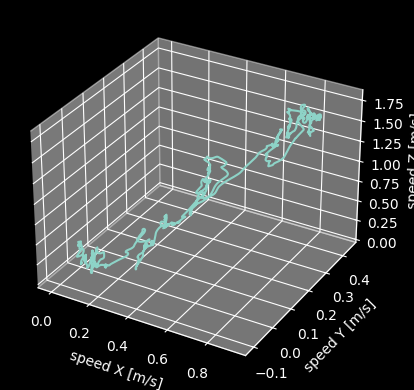

In [138]:
ax2 = plt.figure().add_subplot(projection='3d')
ax2.plot(curve.x_speed_list, curve.y_speed_list, curve.z_speed_list, label='speed curve')
ax2.set_xlabel('speed X [m/s]')
ax2.set_ylabel('speed Y [m/s]')
ax2.set_zlabel('speed Z [m/s]')
# data.to_csv('output.csv')

# print('Lack of testing code')

# Adding scanner points to path

## Get points data from database

In [139]:
data_scanner=db_client.get_scanner_data('scan_sensor_test', time_start, time_stop).dropna()
data_scanner['points_Z'] = data_scanner['points_Z'] + 70
# Zastosuj kompensację o 70 mm związaną z debilnymi współrzędnymi tego skanera
# Początek ukłądu współrzędnych skanera leży na wierzchu szybki od lasera

In [140]:
data_scanner.head()

,point_X,points_Z,time_rel
_time,,,
2023-09-24 15:46:29.829697+00:00,-33.843384,26.101685,12.291443
2023-09-24 15:46:29.829698+00:00,-33.731689,25.936890,12.291443
2023-09-24 15:46:29.829699+00:00,-33.567871,25.762939,12.291443
2023-09-24 15:46:29.829700+00:00,-33.418945,25.588989,12.291443
2023-09-24 15:46:29.829701+00:00,-33.307251,25.415039,12.291443


In [141]:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                           'display.precision', 6,
                           ):
        print(data_scanner.describe())

             point_X       points_Z       time_rel
count  786274.000000  786274.000000  786274.000000
mean       -3.882368      28.348797      20.011373
std        18.271351      14.606036       4.367915
min       -44.491577       0.009155      12.291443
25%       -18.660400      17.642212      16.460759
50%        -5.123047      26.916504      19.920522
75%         9.628052      36.712646      23.920693
max        52.473999     110.659790      27.611716


In [142]:
# Set time as index
data_scanner.set_index('time_rel', inplace=True)
# Change index column name for it to be compatible with other data
# data_scanner.index.names=['time_rel']

### Interpolate device information for data points 

In [143]:
# Copy scanner data
index_tmp_df = data_scanner.copy()

# Leave only indexes without duplicates
index_tmp_df=index_tmp_df[~index_tmp_df.index.duplicated(keep='first')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                        'display.precision', 6,
                        ):
    print(index_tmp_df.describe())

           point_X     points_Z
count  1553.000000  1553.000000
mean    -34.271222    30.194994
std       4.038730    16.192831
min     -44.491577     0.009155
25%     -35.920898    17.807007
50%     -34.223145    29.351807
75%     -31.810547    37.454224
max      -8.228149    77.279663


In [144]:
# Drop points columns to leave only 
index_tmp_df=index_tmp_df.drop(columns=['point_X','points_Z'])

In [145]:
len(index_tmp_df)

1553

In [146]:
interpolation_df= pd.concat([index_tmp_df, data[['theta_hat','phi_hat','psi_hat']]], ignore_index=False, join='outer')
interpolation_df.sort_index(inplace=True)
interpolation_df.interpolate(inplace=True)

In [147]:
index_tmp_df.index

Index([ 12.29144287109375, 12.293271780014038, 12.295151948928833,
       12.297240972518921, 12.299400806427002, 12.301898956298828,
       12.304308891296387, 12.306336879730225, 12.308670997619629,
       12.311097860336304,
       ...
       27.520723819732666,  27.53075098991394, 27.540790796279907,
       27.551426887512207, 27.560670852661133, 27.571122884750366,
       27.580787897109985, 27.591036796569824, 27.600986003875732,
        27.61171579360962],
      dtype='float64', name='time_rel', length=1553)

In [148]:
interpolated_angles = interpolation_df.loc[index_tmp_df.index.values]

In [149]:
interpolated_angles.head()

,theta_hat,phi_hat,psi_hat
time_rel,,,
12.291443,-0.398643,0.014428,0.094615
12.293272,-0.398598,0.015058,0.094744
12.295152,-0.398961,0.015130,0.094823
12.297241,-0.400752,0.014791,0.094978
12.299401,-0.408206,0.014349,0.095232


In [150]:
# data_scanner_dev_frame.head()

## Rotate scanner points vectors to device default frame

In [151]:
# Go from scanner frame coordinates, to device coordinates
data_scanner_dev_frame = pd.DataFrame()
data_scanner_dev_frame['Z']=-data_scanner['points_Z']
data_scanner_dev_frame['Y']=-data_scanner['point_X']
data_scanner_dev_frame['X']=0.0
# Add device euler angles
# data_scanner_dev_frame = pd.concat([interpolated_angles,data_scanner_dev_frame], axis = 1, join = 'inner')
data_scanner_dev_frame = data_scanner_dev_frame.join(interpolated_angles)

with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(data_scanner_dev_frame.head())

               Z       Y    X  theta_hat  phi_hat  psi_hat
time_rel                                                  
12.291   -26.102  33.843  0.0     -0.399    0.014    0.095
12.291   -25.937  33.732  0.0     -0.399    0.014    0.095
12.291   -25.763  33.568  0.0     -0.399    0.014    0.095
12.291   -25.589  33.419  0.0     -0.399    0.014    0.095
12.291   -25.415  33.307  0.0     -0.399    0.014    0.095


In [152]:
# Rotate point vectors with device euler angles in order to get global point translation vectors
points_translation = translator.rotate_vect(data_scanner_dev_frame)


In [153]:
print( points_translation)

                 X_e        Y_e        Z_e
time_rel                                  
12.291443   6.664243  35.002593 -23.602519
12.291443   6.611966  34.883059 -23.452147
12.291443   6.561379  34.711201 -23.294031
12.291443   6.509301  34.554158 -23.135717
12.291443   6.453499  34.434157 -22.976909
...              ...        ...        ...
27.611716  43.027037   4.508844 -72.243695
27.611716  45.817864   1.788709 -72.063336
27.611716  45.908894   1.687160 -72.036737
27.611716  46.038609   1.601712 -72.094550
27.611716  46.129639   1.500163 -72.067951

[786274 rows x 3 columns]


## calculate points position in earth frame

In [154]:
# interpolate positions from curve

int_curve_df= pd.concat([index_tmp_df, curve_df], ignore_index=False, join='outer')
int_curve_df.sort_index(inplace=True)
int_curve_df.interpolate(inplace=True)
int_curve_df.head()

,X_p_e,Y_p_e,Z_p_e
8.462264,0.000000e+00,0.000000e+00,0.000000e+00
8.463241,8.180768e-08,7.022543e-09,1.085745e-08
8.464270,3.213529e-07,2.464390e-08,5.121772e-08
8.465326,6.940334e-07,4.283508e-08,1.269674e-07
8.466210,1.084503e-06,5.788927e-08,2.112064e-07


In [155]:
interpolated_curve = int_curve_df.loc[index_tmp_df.index.values]
interpolated_curve.describe()

,X_p_e,Y_p_e,Z_p_e
count,1553.000000,1553.000000,1553.000000
mean,1.928559,0.401733,3.712754
std,1.795522,0.593701,3.287918
min,0.041921,-0.065892,0.336732
25%,0.287731,0.001495,0.906428
50%,1.399199,0.061560,2.523744
75%,3.226451,0.625932,6.013027
max,6.067005,2.042748,11.652393


In [156]:
interpolated_curve.head()

,X_p_e,Y_p_e,Z_p_e
12.291443,0.041921,0.009574,0.336732
12.293272,0.041996,0.009624,0.336905
12.295152,0.042036,0.009650,0.336996
12.297241,0.042113,0.009701,0.337174
12.299401,0.042226,0.009775,0.337438


### Calculate final points on curve

In [157]:
vects_and_curve = interpolated_curve.join(points_translation)
vects_and_curve.head()

,X_p_e,Y_p_e,Z_p_e,X_e,Y_e,Z_e
12.291443,0.041921,0.009574,0.336732,6.664243,35.002593,-23.602519
12.291443,0.041921,0.009574,0.336732,6.611966,34.883059,-23.452147
12.291443,0.041921,0.009574,0.336732,6.561379,34.711201,-23.294031
12.291443,0.041921,0.009574,0.336732,6.509301,34.554158,-23.135717
12.291443,0.041921,0.009574,0.336732,6.453499,34.434157,-22.976909


In [158]:
final_points = pd.DataFrame()
final_points['X'] = vects_and_curve['X_p_e']+vects_and_curve['X_e']/1000
final_points['Y'] = vects_and_curve['Y_p_e']+vects_and_curve['Y_e']/1000
final_points['Z'] = vects_and_curve['Z_p_e']+vects_and_curve['Z_e']/1000


Text(0.5, 0, 'position Z [m]')

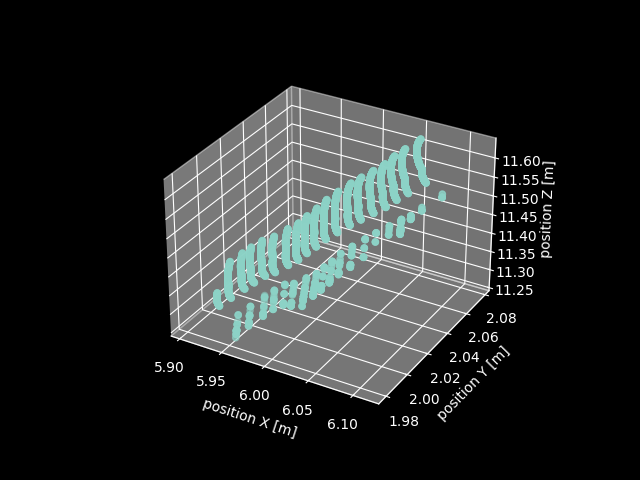

In [159]:
%matplotlib widget
ax3 = plt.figure().add_subplot(projection='3d')
ax3.scatter(final_points.tail(8000)['X'], final_points.tail(8000)['Y'], final_points.tail(8000)['Z'], label='points')
#ax3.set_xlim([-0.1,0.1])
#ax3.set_ylim([-2,-1])
#ax3.set_zlim([0.3,0.5])
ax3.set_xlabel('position X [m]')
ax3.set_ylabel('position Y [m]')
ax3.set_zlabel('position Z [m]')

### Reorganize data to make it usable in optimizer


In [160]:
# Input structure for device curve
#       input_structure = [{'mean_time_rel': 0.0,
#                          'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#                          'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#                          'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]}]
#                          scanner points must be in device frame as it won't change
from scipy.spatial.transform import Rotation


positions = []
for index in index_tmp_df.index:
    # 'mean_time_rel': 0.0,
    time_rel_in = index
    
    # 'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    pos_row = interpolated_curve.loc[index]
    dev_pos_in = {'X':pos_row['X_p_e'],'Y':pos_row['Y_p_e'],'Z':pos_row['Z_p_e']}
    
    # 'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    rot_row = interpolated_angles.loc[index]
    ang_names = ['psi_hat', 'theta_hat', 'phi_hat']
    rot = Rotation.from_euler('ZYX', [rot_row[ang_names[0]], rot_row[ang_names[1]], rot_row[ang_names[2]]], degrees=False)
    rot_vect = rot.as_rotvec()
    dev_rot_in = {'X':rot_vect[0],'Y':rot_vect[1],'Z':rot_vect[2]}
    
    # 'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]
    scanner_points_in = []
    for point in data_scanner_dev_frame.loc[index].iterrows():
        scanner_points_in.append({'X': point[1]['X']/1000, 'Y': point[1]['Y']/1000, 'Z': point[1]['Z']/1000})
        
    # input_structure list filling
    positions.append({'time_rel': index,
                      'dev_pos': dev_pos_in,
                      'dev_rot_vect': dev_rot_in,
                      'scanner_points': scanner_points_in.copy()})

# import json
# with open('/media/adamw/DATA/Projekty/Praca_mgr/scan_3d_MGR/gui_server/DataAnalysisClasses/test.json', 'w') as fout:
#     json.dump(positions , fout)


In [161]:
data_joined.head()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
_time,,,,,,,,,,,,,
2023-09-24 15:46:26.001000+00:00,8.462264,0.229026,0.030731,9.840397,-0.129586,7.155949,2.839440,0.0,0.0,0.0,0.227115,0.031064,9.839432
2023-09-24 15:46:26.002000+00:00,8.463241,0.208026,0.006491,9.836892,-1.465177,5.039604,1.408809,0.0,0.0,0.0,0.206847,0.006276,9.836134
2023-09-24 15:46:26.003000+00:00,8.464270,0.210892,0.014773,9.860020,0.347856,7.931311,3.621982,0.0,0.0,0.0,0.208630,0.015321,9.858999
2023-09-24 15:46:26.004000+00:00,8.465326,0.234323,-0.019937,9.828537,0.410615,6.786788,2.643544,0.0,0.0,0.0,0.232770,-0.019610,9.827631
2023-09-24 15:46:26.005000+00:00,8.466210,0.222232,0.041137,9.837285,-0.065895,7.318213,3.003422,0.0,0.0,0.0,0.220253,0.041449,9.836250


In [162]:
data_joined.keys()

Index(['time_rel', 'acc_X_b', 'acc_Y_b', 'acc_Z_b', 'gyro_X_b', 'gyro_Y_b',
       'gyro_Z_b', 'gyro_X_b_der', 'gyro_Y_b_der', 'gyro_Z_b_der', 'acc_X_t',
       'acc_Y_t', 'acc_Z_t'],
      dtype='object')

In [163]:
cols_list = ['time_rel','gyro_X_b', 'gyro_Y_b', 'gyro_Z_b', 'acc_X_t','acc_Y_t', 'acc_Z_t']
cols_rename = {'gyro_X_b':'X_gyr',
               'gyro_Y_b':'Y_gyr',
               'gyro_Z_b':'Z_gyr',
               'acc_X_t':'X_acc',
               'acc_Y_t':'Y_acc',
               'acc_Z_t':'Z_acc'}
data_joined.loc[(data_joined['time_rel']>=14.1) &(data_joined['time_rel']<=14.11)][cols_list].copy().rename(columns = cols_rename).to_dict('records')

[{'time_rel': 14.100277414416322,
  'X_gyr': -2.6143041375147638,
  'Y_gyr': 8.196428625083106,
  'Z_gyr': 3.6750005536834793,
  'X_acc': 3.660222562625652,
  'Y_acc': 0.4889680388982603,
  'Z_acc': 9.074735859995736},
 {'time_rel': 14.1013316907505,
  'X_gyr': -2.1172718925239455,
  'Y_gyr': 8.64848523886149,
  'Z_gyr': 4.002093995187091,
  'X_acc': 3.658943596244071,
  'Y_acc': 0.4749817294321006,
  'Z_acc': 9.116645189670615},
 {'time_rel': 14.102270373810244,
  'X_gyr': -1.739004592133685,
  'Y_gyr': 8.128184354283386,
  'Z_gyr': 3.672221732054463,
  'X_acc': 3.6810814395213507,
  'Y_acc': 0.4715859763783291,
  'Z_acc': 9.078384805490044},
 {'time_rel': 14.103260559610801,
  'X_gyr': -1.960891889897713,
  'Y_gyr': 7.316777851571216,
  'Z_gyr': 3.931827950636354,
  'X_acc': 3.6692844672911176,
  'Y_acc': 0.49681329807340247,
  'Z_acc': 9.073757968943253},
 {'time_rel': 14.1041798056549,
  'X_gyr': -1.357612807627608,
  'Y_gyr': 8.126047801170754,
  'Z_gyr': 4.440828980654821,
  'X_a

In [164]:
index_tmp_df.index[0]

12.29144287109375

In [165]:
# Input structure for new device curve
# [{'mean_time_rel': 0.0,
#   'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_speed': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_euler_ang': {'psi': 0.0, 'theta': 0.0, 'phi': 0.0},
#   'imu_input':[{'mean_time_rel': 0.0,
#                 'X_acc': 0.0, 'Y_acc': 0.0, 'Z_acc': 0.0,
#                 'X_gyr': 0.0, 'Y_gyr': 0.0, 'Z_gyr': 0.0}],
#   'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]}]


cols_list = ['time_rel','gyro_X_b', 'gyro_Y_b', 'gyro_Z_b', 'acc_X_t','acc_Y_t', 'acc_Z_t']
cols_rename = {'gyro_X_b':'X_gyr',
               'gyro_Y_b':'Y_gyr',
               'gyro_Z_b':'Z_gyr',
               'acc_X_t':'X_acc',
               'acc_Y_t':'Y_acc',
               'acc_Z_t':'Z_acc'}


positions = []
# prev_time = 0.0
# min_time = data_joined['time_rel'].min()
prev_time = 9
min_time = prev_time
for index in index_tmp_df.index:
    # 'mean_time_rel': 0.0,
    time_rel_in = index - min_time
    
    # 'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    dev_pos_in = None
    
    #'dev_speed': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    dev_speed_in = None
    
    # 'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    dev_rot_in = None
    
    # 'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]
    scanner_points_in = []
    for point in data_scanner_dev_frame.loc[index].iterrows():
        scanner_points_in.append({'X': point[1]['X']/1000, 'Y': point[1]['Y']/1000, 'Z': point[1]['Z']/1000})
        
    # 'dev_euler_ang': {'psi': 0.0, 'theta': 0.0, 'phi': 0.0},
    dev_euler_ang_in = None
    
    # 'imu_input':[{'mean_time_rel': 0.0,
    #               'X_acc': 0.0, 'Y_acc': 0.0, 'Z_acc': 0.0,
    #               'X_gyr': 0.0, 'Y_gyr': 0.0, 'Z_gyr': 0.0}],
    imu_input_in = data_joined.loc[(
        data_joined['time_rel']>=prev_time) & (
        data_joined['time_rel']<index)][cols_list].copy().rename(columns = cols_rename).to_dict('records')
    
    for row in imu_input_in:
        row['time_rel'] = row['time_rel'] - min_time
    
    # input_structure list filling
    positions.append({'time_rel': time_rel_in,
                      'dev_pos': dev_pos_in,
                      'dev_speed': dev_speed_in,
                      'dev_rot_vect': dev_rot_in,
                      'dev_euler_ang': dev_euler_ang_in,
                      'imu_input': imu_input_in.copy(),
                      'scanner_points': scanner_points_in.copy()})
# [{'mean_time_rel': 0.0,
#   'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_speed': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_euler_ang': {'psi': 0.0, 'theta': 0.0, 'phi': 0.0},
#   'imu_input':[{'mean_time_rel': 0.0,
#                 'X_acc': 0.0, 'Y_acc': 0.0, 'Z_acc': 0.0,
#                 'X_gyr': 0.0, 'Y_gyr': 0.0, 'Z_gyr': 0.0}],
#   'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]}]
    
    
    
    prev_time = index
    
    


In [166]:
if True:
    import json
    with open('/mnt/DATA/Projekty/Praca_mgr/scan_3d_MGR/gui_server/DataAnalysisClasses/test9.json', 'w') as fout:
        json.dump(positions , fout)

In [ ]:
positions[2]

In [ ]:
positions[0]['imu_input'][3000]